# Graph4Air: GNN Workflow

Welcome to the Graph4Air notebook! This end-to-end pipeline leverages Graph Neural Networks (GCN & GAT) to predict NO₂ levels on road segments. Follow the sections below to reproduce the full workflow:

## Table of Contents

### 1. Setup & Imports
1. **1.1 Environment Setup**  
   Install and configure all required libraries (PyTorch-Geometric, Optuna, etc.).  
2. **1.2 Core Imports & Drive Mount**  
   Import key Python packages for data, geospatial processing, graphs, ML metrics, plotting, GNNs, and mount Google Drive.

### 2. Data & Graph Preparation
3. **2.1 Data Loading & Preprocessing**  
   Load road-network and Palmes tube GeoJSONs, compute centroids, define features & target.  
4. **2.2 Constructing the Road Network Graph**  
   Build a NetworkX graph connecting physically touching segments.  
5. **2.3 Outlier Detection & Classification**  
   Identify spatial outliers in NO₂ measurements; classify as errors or real extremes.  
6. **2.4 Graph Augmentation with Best Parameters**  
   Add far-range “feature_sim” edges based on grouped land-use similarity.  
7. **2.5 Visualize Augmented Edges**  
   Plot original vs. augmented edges for sanity checks.  
8. **2.6 Visualize the GCN Augmented Graph**  
   Render the GCN-specific augmented graph.  
9. **2.7 Visualize the GAT Augmented Graph**  
   Render the GAT-specific augmented graph.  
10. **2.8 Normalize Feature Columns**  
    Standardize features to zero mean and unit variance.  
11. **2.9 Prepare PyTorch-Geometric Data**  
    Convert graphs into `torch_geometric.data.Data` objects with masks (excluding error segments).

### 3. Modeling & Evaluation
12. **3.1 Define GCN & GAT Architectures**  
    Implement parameterized GCN and GAT classes.  
13. **3.2 Train & Evaluate GCN**  
    Train the GCN with optimal hyperparameters; plot losses and scatter actual vs. predicted.  
14. **3.3 External Validation – GCN**  
    Aggregate GCN predictions at Palmes-tube sites; compute RMSE, MAE, R², Pearson.  
15. **3.4 Train & Evaluate GAT**  
    Train the GAT with optimal hyperparameters; visualize performance.  
16. **3.5 External Validation – GAT**  
    Aggregate GAT predictions at Palmes-tube sites; report external metrics and scatter plot.

> **Tip:** Run each cell in order to reproduce the entire workflow from raw data to final evaluation.


## 1.1 Environment Setup

First, install the Python packages we need:  
- **Optuna** for hyperparameter tuning  
- **PyTorch-Geometric** (and its dependencies) for graph neural networks  

In [3]:
import torch

!pip install optuna -q
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y -q
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html -q
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html -q
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html -q
!pip install git+https://github.com/pyg-team/pytorch_geometric.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 1.2. Core Imports & Drive Mount

In this section we load all the Python packages required for data handling, geospatial operations, graph building, machine-learning metrics, plotting, GNN layers and hyperparameter tuning. We then mount Google Drive for seamless data access.

- **Utilities**:  
  - `os`, `random`, `Counter`  
- **Numerical & Tabular**:  
  - `numpy as np`, `pandas as pd`  
- **Geospatial & Graph**:  
  - `geopandas as gpd`, `networkx as nx`  
- **Data transformations**:
  - `pickle as pickle`
- **ML Helpers & Metrics**:  
  - `sklearn.neighbors.NearestNeighbors`  
  - `sklearn.preprocessing.StandardScaler`  
  - `sklearn.metrics.{mean_squared_error, mean_absolute_error, r2_score}`  
  - `scipy.stats.pearsonr`  
- **Visualization & Progress Bars**:  
  - `matplotlib.pyplot as plt`  
  - `seaborn as sns`
  - `tqdm.auto.tqdm`  
- **PyTorch & PyTorch-Geometric**:  
  - `torch`, `torch.nn`, `torch.nn.functional as F`  
  - `torch_geometric.data.Data`, `torch_geometric.nn.{GCNConv, GATConv}`  
- **Hyperparameter Tuning**:  
  - `optuna`, `optuna.samplers.TPESampler`  
- **Drive Mount**:  
  - `google.colab.drive`

In [4]:
# core imports
import os, random
from collections import Counter

import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import pickle as pickle

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv

import optuna
from optuna.samplers import TPESampler

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.1 Data Loading & Preprocessing

In this section we load the road‐segment GeoJSON and the Palmes NO₂ measurements, ensure both are in the same projection, reset the index for consistent node IDs, compute segment centroids for later spatial operations, and define our feature and target columns.


In [5]:
# 2.1.1) Load your street segments GeoJSON and reproject to EPSG:28992
fp = '/content/drive/MyDrive/Universiteit Utrecht/Thesis/data/road_network_lufeature.geojson'
gdf = gpd.read_file(fp).to_crs(epsg=28992)

# 2.1.2) Load Palmes NO₂ measurements and align CRS with road segments
palmes_fp   = '/content/drive/MyDrive/Universiteit Utrecht/Thesis/data/road_palmes_25m.geojson'
palmes_gdf  = gpd.read_file(palmes_fp).to_crs(gdf.crs)

# 2.2) Reset the GeoDataFrame index so that each row index is the graph node ID
gdf = gdf.reset_index(drop=True)

# 2.3) Compute centroids and build a NumPy array of coordinates for plotting and distance checks
gdf['centroid'] = gdf.geometry.centroid
coords = np.vstack([ (pt.x, pt.y) for pt in gdf.centroid ])

# 2.4) Define the list of feature columns and the target column
feature_cols = [
    'AGRI_100','INDUS_100','NATUR_100','PORT_100','RES_100','TRANS_100','URBG_100','WATER_100',
    'AGRI_300','INDUS_300','NATUR_300','PORT_300','RES_300','TRANS_300','URBG_300','WATER_300',
    'AGRI_500','INDUS_500','NATUR_500','PORT_500','RES_500','TRANS_500','URBG_500','WATER_500',
    'AGRI_1000','INDUS_1000','NATUR_1000','PORT_1000','RES_1000','TRANS_1000','URBG_1000','WATER_1000',
    'AGRI_5000','AIR_5000','INDUS_5000','NATUR_5000','PORT_5000','RES_5000','TRANS_5000','URBG_5000','WATER_5000',
    'POP_100','POP_300','POP_500','POP_1000','POP_5000',
    'EEA_100','EEA_300','EEA_500','EEA_1000','EEA_5000',
    'HHOLD_100','HHOLD_300','HHOLD_500','HHOLD_1000',
    'RDL_25','TLOA_25','HLOA_25','MRDL_25','TMLOA_25','HMLOA_25',
    'RDL_50','TLOA_50','HLOA_50','MRDL_50','TMLOA_50','HMLOA_50',
    'RDL_100','TLOA_100','HLOA_100','MRDL_100','TMLOA_100','HMLOA_100',
    'RDL_300','TLOA_300','HLOA_300','MRDL_300','TMLOA_300','HMLOA_300',
    'RDL_500','TLOA_500','HLOA_500','MRDL_500','TMLOA_500','HMLOA_500',
    'RDL_1000','TLOA_1000','HLOA_1000','MRDL_1000','TMLOA_1000','HMLOA_1000',
    'TRAFNEAR','HTRAFNEAR','DINVNEAR','TRAFMAJOR','HTRAFMAJOR','DINVMAJOR'
]
target_col = 'NO2d'

## 2.2 Constructing the Road Network Graph

The `build_road_graph` function creates a NetworkX graph from the road‐segment GeoDataFrame. Each segment becomes a node, and edges connect segments that physically touch. We also optionally:

- Print summary statistics (node/edge counts, degree distribution).
- Plot the graph, coloring nodes by whether they have missing target or feature values.
- Save the graph object to Google Drive.

In [6]:
def build_road_graph(
    gdf,
    feature_cols,
    target_col,
    plot_graph=True,
    print_stats=True,
    save_to_drive_path=None
):
    """
    Constructs a NetworkX graph from a GeoDataFrame where each segment is a node
    and edges connect touching segments. Nodes are not dropped for missing data.

    Parameters:
    - gdf: GeoDataFrame with road segments
    - feature_cols: list of feature column names
    - target_col: name of the target variable
    - plot_graph: whether to visualize the graph with node coloring by missing data
    - print_stats: whether to print node/edge counts and degree stats
    - save_to_drive_path: if provided, saves the graph object using pickle

    Returns:
    - G: NetworkX graph
    - gdf: Original GeoDataFrame (reset index)
    """

    gdf = gdf.copy().reset_index(drop=True)
    G = nx.Graph()

    # Identify which nodes have missing target or features
    missing_target   = gdf[target_col].isnull()
    missing_features = gdf[feature_cols].isnull().any(axis=1)

    if print_stats:
        print(f"Total nodes: {len(gdf)}")
        print(f"Nodes with missing target ({target_col}): {missing_target.sum()}")
        print(f"Nodes with missing feature(s): {missing_features.sum()}")

    # Add each segment as a node, carrying all its attributes
    print("Adding nodes...")
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Nodes"):
        G.add_node(idx, **row.drop('geometry').to_dict())

    # Build spatial index for fast neighbor lookup
    print("Building spatial index...")
    subset_sindex = gdf.sindex

    # Add edges between touching segments
    print("Adding edges...")
    for idx, geom in tqdm(enumerate(gdf.geometry), total=len(gdf), desc="Edges"):
        possible_neighbors = list(subset_sindex.intersection(geom.bounds))
        for nbr in possible_neighbors:
            if idx != nbr and geom.touches(gdf.geometry[nbr]):
                G.add_edge(idx, nbr)

    if print_stats:
        print(f"Number of edges: {G.number_of_edges()}")
        degs = [d for _, d in G.degree()]
        print(f"Average degree: {sum(degs)/len(degs):.2f}")

    # Optionally plot the graph and color nodes by missing data status
    if plot_graph:
        pos = {i: (geom.centroid.x, geom.centroid.y) for i, geom in enumerate(gdf.geometry)}
        colors = [
            'red'    if missing_target[i]
            else 'orange' if missing_features[i]
            else 'blue'
            for i in range(len(gdf))
        ]
        plt.figure(figsize=(10, 10))
        nx.draw(G, pos, node_size=10, edge_color='gray', node_color=colors, with_labels=False)
        # Legend
        import matplotlib.patches as mpatches
        legend_handles = [
            mpatches.Patch(color='red',    label='Missing target'),
            mpatches.Patch(color='orange', label='Missing features'),
            mpatches.Patch(color='blue',   label='No missing data'),
        ]
        plt.legend(handles=legend_handles, loc='upper right')
        plt.axis('equal')
        plt.show()

    # Optionally save the graph to Drive
    if save_to_drive_path:
        with open(save_to_drive_path, 'wb') as f:
            pickle.dump(G, f)
        if print_stats:
            print(f"💾 Graph saved to: {save_to_drive_path}")

    return G, gdf

# Invoke the function:
G, gdf = build_road_graph(
    gdf, feature_cols, target_col,
    plot_graph=False,   # turn off plotting here
    print_stats=True,   # keep stats output
    save_to_drive_path=None
)

Total nodes: 48595
Nodes with missing target (NO2d): 1931
Nodes with missing feature(s): 0
Adding nodes...


Nodes:   0%|          | 0/48595 [00:00<?, ?it/s]

Building spatial index...
Adding edges...


Edges:   0%|          | 0/48595 [00:00<?, ?it/s]

Number of edges: 56998
Average degree: 2.35


## 2.3 Outlier Detection & Classification

We identify “spatial outliers” in the NO₂ measurements and then classify them into **errors** (to drop) vs **real extremes** (to keep) using three heuristics:

1. **Palmes Tube Comparison**  
   Compare to nearby official Palmes‐tube readings (within 50 m).  
   If segment value > 2× Palmes mean → **error**, else **real extreme**.

2. **Neighborhood Agreement**  
   If > 50 % of neighbors within 200 m are also above the 75th percentile → **real extreme**.

3. **Traffic‐based Prediction**  
   Fit `NO2d ~ TRAFNEAR`.  
   If |residual| > 3× RMSE → **error**, else **real extreme**.

All **error** segments will be excluded from training masks to avoid bias.


In [7]:
def detect_outliers(G, gdf, target_col, group_col, group_thresholds, hop=1, default_thresh=3.0):
    """
    Flag nodes whose NO₂ deviation from 1‐hop neighbor mean exceeds
    (threshold × MAD). Threshold differs by group_col.
    """
    nodes = list(G.nodes())
    vals, neigh_means = [], []
    for n in nodes:
        v = gdf.at[n, target_col]
        if pd.isna(v):
            vals.append(np.nan); neigh_means.append(np.nan)
            continue
        # collect neighbor values
        sp = nx.single_source_shortest_path_length(G, n, cutoff=hop)
        nbrs = [m for m in sp if m != n]
        nbr_vals = gdf.loc[nbrs, target_col].dropna().values
        vals.append(v)
        neigh_means.append(np.nan if nbr_vals.size==0 else nbr_vals.mean())

    vals = np.array(vals)
    neigh_means = np.array(neigh_means)
    valid = ~np.isnan(vals) & ~np.isnan(neigh_means)
    residuals = vals[valid] - neigh_means[valid]
    valid_nodes = np.array(nodes)[valid]

    med = np.median(residuals)
    mad = np.median(np.abs(residuals - med))
    # per‐node cutoff using group‐specific multiplier
    cutoffs = np.array([
        group_thresholds.get(gdf.at[n, group_col], default_thresh) * mad
        for n in valid_nodes
    ])
    return valid_nodes[np.abs(residuals - med) > cutoffs].tolist()


def classify_outliers(G, gdf, target_col, outlier_segs, palmes_gdf, traffic_col='TRAFNEAR'):
    """
    Split outlier_segs into 'errors' vs 'real extremes' using:
      1) Palmes comparison
      2) Neighborhood agreement
      3) Traffic‐based prediction
    """
    # fit traffic → NO₂ model
    mask = gdf[target_col].notna() & gdf[traffic_col].notna()
    X = gdf.loc[mask, traffic_col].values.reshape(-1,1)
    y = gdf.loc[mask, target_col].values
    lr = LinearRegression().fit(X, y)
    rmse_traf = np.sqrt(mean_squared_error(y, lr.predict(X)))
    hot_thresh = np.percentile(gdf[target_col].dropna(), 75)

    errors, reals = [], []
    for seg in outlier_segs:
        val  = gdf.at[seg, target_col]
        pt   = gdf.geometry[seg]
        traf = gdf.at[seg, traffic_col]

        # 1) Palmes tube
        nearby = palmes_gdf[palmes_gdf.distance(pt) <= 50]
        if len(nearby):
            pal_val = nearby['mean_annual_palmes_no2'].mean()
            (errors if val > 2 * pal_val else reals).append(seg)
            continue

        # 2) Neighborhood agreement
        nbrs     = list(gdf.sindex.intersection(pt.buffer(200).bounds))
        nbr_vals = gdf.loc[nbrs, target_col].dropna()
        if len(nbr_vals) and (nbr_vals > hot_thresh).mean() > 0.5:
            reals.append(seg)
            continue

        # 3) Traffic prediction
        if not np.isnan(traf):
            pred = lr.predict([[traf]])[0]
            (errors if abs(val - pred) > 3 * rmse_traf else reals).append(seg)
            continue

        # default: keep as real extreme
        reals.append(seg)

    return errors, reals


# Run detection & classification
gdf['is_highway'] = gdf['TRAFMAJOR'] > 20000
group_thresh     = {True: 9.0, False: 5.0}

outliers    = detect_outliers(G, gdf, target_col='NO2d',
                              group_col='is_highway',
                              group_thresholds=group_thresh)
error_segs, real_segs = classify_outliers(G, gdf, 'NO2d', outliers, palmes_gdf)

print(f"Outliers flagged: {len(outliers)}")
print(f"   • Errors to drop:     {len(error_segs)}")
print(f"   • Real extremes kept: {len(real_segs)}")

Outliers flagged: 2172
   • Errors to drop:     125
   • Real extremes kept: 2047


## 2.4 Graph Augmentation with Best Parameters

We apply the “far‐range grouped kNN” augmentation using the previously found optimal settings:

- **GCN augmentation** uses `best_graph_params_1`
- **GAT augmentation** uses `best_graph_params_2`

The function below:
1. Loops over each feature‐group.
2. Selects the top‐N segments by group intensity.
3. Builds cosine‐KNN, filters by similarity & spatial/graph distance.
4. Enforces per‐node and global edge caps.
5. Returns the augmented graph and list of new edges.


In [8]:
# Best augmentation settings for GCN & GAT
best_graph_params_1 = dict(
    top_n=500, neighbors=10, sim_thresh=0.9822148454908651,
    min_dist=490, max_dist=1595, hop_thresh=5,
    max_edges=1500, per_node_cap=1
)
best_graph_params_2 = dict(
    top_n=1000, neighbors=180, sim_thresh=0.9834,
    min_dist=167, max_dist=1583, hop_thresh=4,
    max_edges=4500, per_node_cap=2
)

def augment_grouped_far_knn(
    G, gdf, groups, coords, feature_matrix, feature_cols, params, suffix
):
    """
    Augment G by adding semantic edges between far‐range, high‐intensity segments.
    - G: base NetworkX graph
    - gdf: GeoDataFrame of road segments (indexed 0..N-1)
    - groups: dict of feature‐groups
    - coords: Nx2 array of centroids
    - feature_matrix: NxF NumPy array of features
    - feature_cols: list of F column names
    - params: dict of augmentation hyperparameters
    - suffix: tag for new edges’ attribute
    Returns: (G2, new_edges)
    """
    road_ids = gdf['ROAD_FID'].to_numpy()
    candidates = set()

    for cols in groups.values():
        # find top‐N by group intensity
        idxs    = [feature_cols.index(c) for c in cols]
        intensity = gdf[cols].sum(axis=1)
        top_idx   = intensity.nlargest(params['top_n']).index.to_numpy()
        if len(top_idx) < 2:
            continue

        # normalize group features
        subF = feature_matrix[top_idx][:, idxs]
        subF /= np.linalg.norm(subF, axis=1, keepdims=True).clip(1e-6)

        # cosine‐KNN
        nbr = NearestNeighbors(
            n_neighbors=min(len(top_idx), params['neighbors'] + 1),
            metric='cosine'
        ).fit(subF)
        dists, nbrs = nbr.kneighbors(subF)
        sims = 1 - dists

        # propose candidate edges
        for ii, src in enumerate(top_idx):
            close = set(nx.single_source_shortest_path_length(
                G, int(src), cutoff=params['hop_thresh']
            ))
            for rank, dj in enumerate(nbrs[ii, 1:], start=1):
                if sims[ii, rank] < params['sim_thresh']:
                    break
                dst = top_idx[dj]
                u, v = sorted((int(src), int(dst)))
                if road_ids[u] == road_ids[v]:
                    continue
                dxy = np.linalg.norm(coords[u] - coords[v])
                if not (params['min_dist'] <= dxy <= params['max_dist']):
                    continue
                if v in close:
                    continue
                candidates.add((u, v))

    # prune by per‐node & global caps
    final, counts = [], Counter()
    for u, v in random.sample(list(candidates), len(candidates)):
        if counts[u] < params['per_node_cap'] and counts[v] < params['per_node_cap']:
            final.append((u, v))
            counts[u] += 1
            counts[v] += 1
        if len(final) >= params['max_edges']:
            break

    G2 = G.copy()
    G2.add_edges_from(final, feature_sim=suffix)
    return G2, final

# Define the same groups dict once:
groups = {
    'industrial':        ['INDUS_300','INDUS_1000'],
    'residential':       ['RES_300','RES_1000'],
    'agriculture':       ['AGRI_300','AGRI_1000'],
    'natural':           ['NATUR_300','NATUR_1000'],
    'port':              ['PORT_300','PORT_1000'],
    'urb_built':         ['URBG_300','URBG_1000'],
    'water':             ['WATER_300','WATER_1000'],
    'traffic':           ['TRAFNEAR','TRAFMAJOR'],
    'pop':               ['POP_300','POP_1000'],
    'population_density':['EEA_300','EEA_1000'],
}

# Build feature matrix & coords
feature_matrix = gdf[feature_cols].to_numpy()
coords         = np.column_stack((gdf.centroid.x, gdf.centroid.y))

# Augment for GCN
G_GCN, edges_GCN = augment_grouped_far_knn(
    G, gdf, groups, coords, feature_matrix, feature_cols,
    best_graph_params_1, suffix='aug_gcn'
)
print(f"✅ GCN augmented edges: {len(edges_GCN)}")

# Augment for GAT
G_GAT, edges_GAT = augment_grouped_far_knn(
    G, gdf, groups, coords, feature_matrix, feature_cols,
    best_graph_params_2, suffix='aug_gat'
)
print(f"✅ GAT augmented edges: {len(edges_GAT)}")

✅ GCN augmented edges: 775
✅ GAT augmented edges: 4500


## 2.5 Visualize Augmented Edges

The helper function below plots your base graph edges (in light gray) and overlays the newly added `feature_sim` edges (in red).  
- **`G`**: a NetworkX graph whose edges may carry a `feature_sim` attribute.  
- **`coords`**: an \(N \times 2\) NumPy array of node coordinates.  
- **`node_size`**: if >0, nodes are plotted as black dots.  

In [9]:
def plot_aug(
    G,
    coords,
    title=None,
    node_size=0,
    base_edge_kwargs=None,
    new_edge_kwargs=None
):
    """
    Draws G’s original edges in light gray and overlays 'feature_sim' edges in red.

    Parameters
    ----------
    G : networkx.Graph
      Graph whose nodes are integers 0..N-1 and whose edges may carry a
      'feature_sim' attribute flag.
    coords : ndarray of shape (N,2)
      coords[i] = (x_i, y_i) for node i.
    title : str, optional
      Title for the plot.
    node_size : int, default=0
      If >0, draw nodes as black dots of this size.
    base_edge_kwargs : dict, optional
      Passed to nx.draw_networkx_edges for original edges.
    new_edge_kwargs  : dict, optional
      Passed to nx.draw_networkx_edges for 'feature_sim' edges.
    """
    # default styling for original vs. new edges
    base_edge_kwargs = base_edge_kwargs or dict(edge_color='lightgray', alpha=0.5, width=0.5)
    new_edge_kwargs  = new_edge_kwargs  or dict(edge_color='red',        alpha=0.8, width=1.0)

    # build a position mapping for all nodes
    pos = {i: coords[i] for i in G.nodes()}

    plt.figure(figsize=(8, 8))
    # draw all original edges (those without 'feature_sim')
    orig_edges = [(u, v) for u, v, d in G.edges(data=True) if not d.get('feature_sim')]
    nx.draw_networkx_edges(G, pos, edgelist=orig_edges, **base_edge_kwargs)

    # draw only the new 'feature_sim' edges
    new_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('feature_sim')]
    nx.draw_networkx_edges(G, pos, edgelist=new_edges, **new_edge_kwargs)

    # optionally draw nodes
    if node_size > 0:
        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='black')

    if title:
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


## 2.6 Visualize the GCN Augmented Graph

Below, we call `plot_aug` on your GCN‐augmented graph. This will draw the original road‐segment edges in light gray, and overlay the new “feature_sim” edges (≈ `{{len(edges_GCN)}}`) in red.


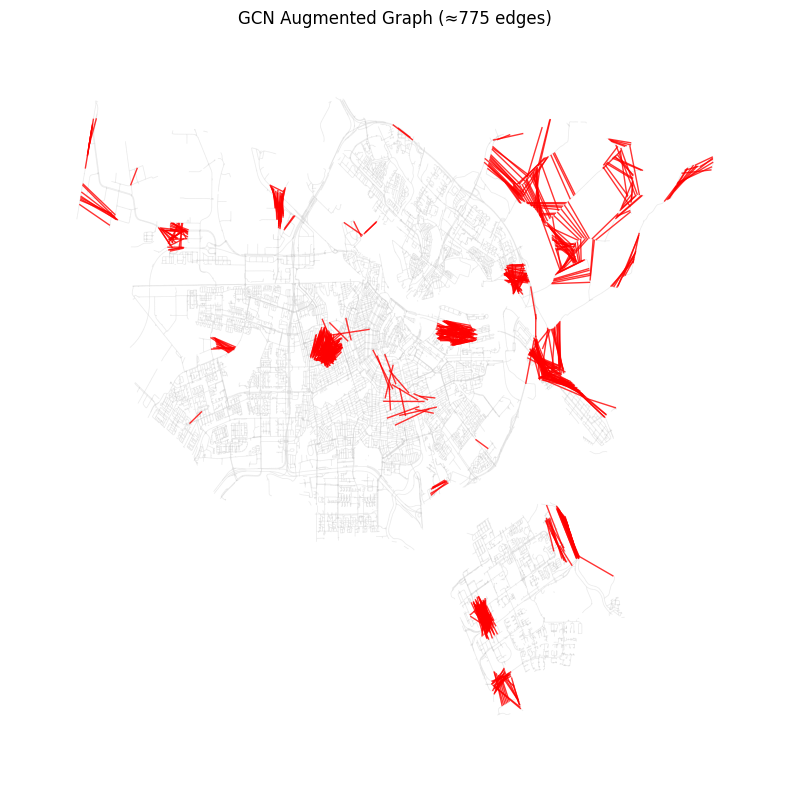

In [10]:
# Visualize the GCN‐augmented graph
plot_aug(
    G_GCN,
    coords,
    title=f"GCN Augmented Graph (≈{len(edges_GCN)} edges)"
)

## 2.7 Visualize the GAT Augmented Graph

Now let’s inspect the GAT‐augmented graph. This will plot the original edges in light gray and overlay the newly added “feature_sim” edges (≈ `{{len(edges_GAT)}}`) in red.

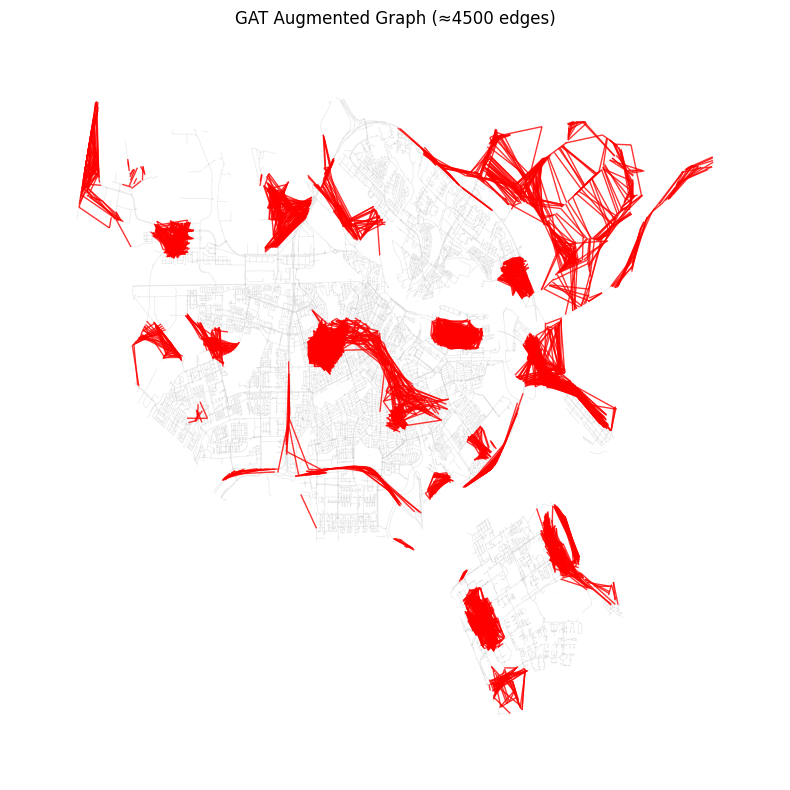

In [11]:
# Visualize the GAT‐augmented graph
plot_aug(
    G_GAT,
    coords,
    title=f"GAT Augmented Graph (≈{len(edges_GAT)} edges)"
)

## 2.8 Normalize Feature Columns

Before feeding features into the GNNs, we standardize all the numeric predictors to zero mean and unit variance. This helps training converge more reliably.


In [12]:
# Standardize all feature columns (zero mean, unit variance)
scaler = StandardScaler()
gdf[feature_cols] = scaler.fit_transform(gdf[feature_cols])

print("✅ Features standardized. First few rows:")
display(gdf[feature_cols].head())

✅ Features standardized. First few rows:


,AGRI_100,INDUS_100,NATUR_100,PORT_100,RES_100,TRANS_100,URBG_100,WATER_100,AGRI_300,INDUS_300,...,HLOA_1000,MRDL_1000,TMLOA_1000,HMLOA_1000,TRAFNEAR,HTRAFNEAR,DINVNEAR,TRAFMAJOR,HTRAFMAJOR,DINVMAJOR
0,-0.206042,-0.278472,-0.036442,-0.310579,0.692772,-0.169784,-0.304,-0.182902,-0.236592,-0.311412,...,-0.733163,-0.219001,-0.439011,-0.693323,-0.110402,-0.261957,-0.035122,-0.024247,-0.200823,-0.010251
1,-0.206042,-0.278472,-0.036442,-0.310579,0.692772,-0.169784,-0.304,-0.182902,-0.236592,-0.311412,...,1.195809,1.197836,1.989651,1.279465,0.310116,-0.226646,-0.035122,0.006073,-0.301406,-0.010251
2,-0.206042,-0.278472,-0.036442,-0.310579,0.692772,-0.169784,-0.304,-0.182902,-0.236592,-0.311412,...,-0.889289,-0.104357,-0.677813,-0.833044,-0.448719,-0.308478,-0.035104,-0.512046,-0.356050,-0.010251
3,-0.206042,-0.278472,-0.036442,-0.310579,0.692772,-0.169784,-0.304,-0.182902,-0.236592,-0.311412,...,-0.781953,-0.395845,-0.683365,-0.819709,-0.452248,-0.308478,-0.035122,-0.380084,-0.307209,-0.010251
4,-0.206042,-0.278472,-0.036442,-0.310579,0.692772,-0.169784,-0.304,-0.182902,-0.236592,-0.311412,...,0.364902,0.584603,-0.314173,-0.192519,-0.444831,-0.308478,-0.035122,-0.506546,-0.358468,-0.010251


## 2.9 Prepare PyTorch-Geometric Data for GCN & GAT

We now relabel the nodes in each augmented graph to match our 0…N–1 indexing, and build two `torch_geometric.data.Data` objects.  The helper function:

1. Builds a **bidirectional** `edge_index` from the NetworkX edges.
2. Loads the standardized feature matrix `x` and the target vector `y`.
3. Splits nodes with **non-NaN** targets into an 80/20 train/test split.
4. Excludes the previously detected **error outliers** (`error_segs`) from the training mask.


In [13]:
# 1) Relabel both augmented graphs to consecutive indices [0..N-1]
mapping = {old: new for new, old in enumerate(gdf.index)}
G_GCN = nx.relabel_nodes(G_GCN, mapping)
G_GAT = nx.relabel_nodes(G_GAT, mapping)

def build_data(G_aug):
    # --- 1) Build bidirectional edge_index
    edges = torch.tensor(list(G_aug.edges), dtype=torch.long).t().contiguous()
    edge_index = torch.cat([edges, edges.flip(0)], dim=1)

    # --- 2) Load features X and labels Y
    x = torch.tensor(gdf[feature_cols].values, dtype=torch.float)
    y_np = gdf[target_col].values.astype(np.float32)
    y = torch.tensor(y_np).view(-1, 1)

    # --- 3) Train/test split on valid (non-NaN) target nodes
    valid_mask = ~np.isnan(y_np)
    valid_idx  = np.where(valid_mask)[0]
    perm       = torch.randperm(len(valid_idx))
    n_train    = int(0.8 * len(valid_idx))
    train_idx  = valid_idx[perm[:n_train]]
    test_idx   = valid_idx[perm[n_train:]]

    train_mask = torch.zeros(len(gdf), dtype=torch.bool)
    test_mask  = torch.zeros(len(gdf), dtype=torch.bool)
    train_mask[train_idx] = True
    test_mask[test_idx]  = True

    # --- 4) Exclude detected error outliers from training
    train_mask[error_segs] = False

    # Assemble the Data object
    data = Data(x=x, edge_index=edge_index, y=y)
    data.train_mask = train_mask
    data.test_mask  = test_mask
    return data

# Build Data objects for both models
data_GCN = build_data(G_GCN)
data_GAT = build_data(G_GAT)

print("✅ Data prepared:")
print(f"  • GCN: {data_GCN.num_nodes} nodes, {data_GCN.edge_index.size(1)} edges")
print(f"  • GAT: {data_GAT.num_nodes} nodes, {data_GAT.edge_index.size(1)} edges")

✅ Data prepared:
  • GCN: 48595 nodes, 115546 edges
  • GAT: 48595 nodes, 122996 edges


## 3.1) Define GCN & GAT architectures (with dynamic hyperparameters)

In this step, we implement two flexible PyTorch‐Geometric models—**Graph Convolutional Network (GCN)** and **Graph Attention Network (GAT)**—that accept named hyperparameters. This makes it easy to instantiate them with the best parameters found by Optuna:

- **`in_channels`**: Dimensionality of input node features  
- **`hidden_channels`**: Number of hidden units per layer  
- **`out_channels`**: Dimensionality of the output (here, 1 for regression)  
- **`num_layers`**: Total number of layers (including first and last)  
- **`dropout`**: Dropout probability applied after each activation  
- **`activation`**: Either `'relu'` or `'elu'`  
- **(GAT only) `heads`**: Number of attention heads  

Below is the code with inline comments explaining each part.

In [14]:
class GCN(nn.Module):
    """
    Graph Convolutional Network with variable depth, width, dropout, and activation.
    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_layers: int = 4,
        dropout: float = 0.2955213064506179,
        activation: str = 'elu'
    ):
        super().__init__()
        # Map activation name to function
        acts = {'relu': F.relu, 'elu': F.elu}
        self.activation = acts[activation]
        self.dropout = dropout

        # Build sequence of GCNConv layers:
        #  - First layer: in_channels → hidden_channels
        #  - Middle layers: hidden_channels → hidden_channels
        #  - Final layer: hidden_channels → out_channels
        layers = [GCNConv(in_channels, hidden_channels)]
        for _ in range(num_layers - 2):
            layers.append(GCNConv(hidden_channels, hidden_channels))
        layers.append(GCNConv(hidden_channels, out_channels))

        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        # Apply each intermediate layer with activation + dropout
        for conv in self.layers[:-1]:
            x = conv(x, edge_index)
            x = self.activation(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        # Final layer: no activation
        return self.layers[-1](x, edge_index)


class GAT(nn.Module):
    """
    Graph Attention Network with variable depth, width, dropout, activation, and heads.
    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_layers: int = 2,
        dropout: float = 0.0,
        activation: str = 'elu',
        heads: int = 2
    ):
        super().__init__()
        acts = {'relu': F.relu, 'elu': F.elu}
        self.activation = acts[activation]
        self.dropout = dropout
        self.heads = heads

        # First GATConv: in_channels → hidden_channels (with `heads` heads)
        self.convs = nn.ModuleList([
            GATConv(in_channels, hidden_channels, heads=heads)
        ])
        # Middle GATConv layers: (hidden_channels*heads) → hidden_channels*heads
        for _ in range(num_layers - 2):
            self.convs.append(
                GATConv(hidden_channels * heads, hidden_channels, heads=heads)
            )
        # Final GATConv: (hidden_channels*heads) → out_channels (single head, no concat)
        self.out = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        # Apply each attention layer with activation + dropout
        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.activation(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        # Final attention layer
        return self.out(x, edge_index)

## 3.2) Train & Evaluate GCN with Optimal Hyperparameters

In this cell, we:

1. Move the pre-built `data_GCN` to the selected device (CPU or GPU).  
2. Instantiate the `GCN` model using the best hyperparameters discovered by Optuna.  
3. Define the optimizer (Adam) and MSE loss.  
4. Run a training loop for 200 epochs, recording both training and validation losses.  
5. After training, compute test-set metrics (RMSE, MAE, R², Pearson’s ρ).  
6. Plot the loss curves and a scatter of actual vs. predicted NO₂ values.

GCN Test RMSE: 8.009, MAE: 5.578, R²: 0.591, Pearson: 0.773


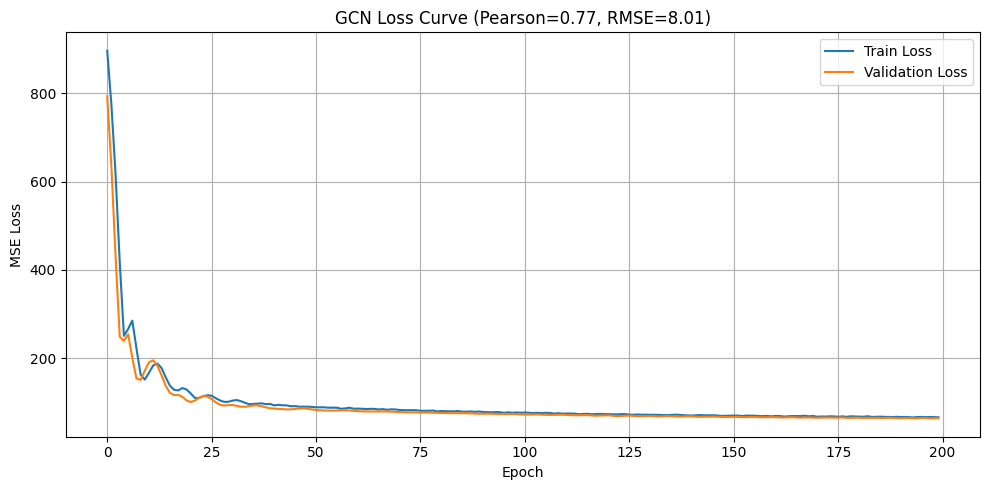

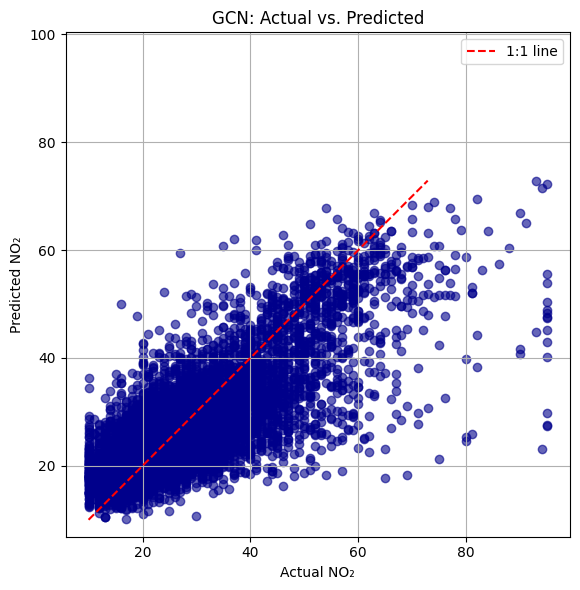

In [15]:
# Move data to GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data_GCN.to(device)

# Instantiate GCN with the optimal Optuna hyperparameters
model_GCN = GCN(
    in_channels    = len(feature_cols),   # number of input features
    hidden_channels= 64,                  # best hidden size
    out_channels   = 1,                   # regression output
    num_layers     = 4,                   # best depth
    dropout        = 0.2955213064506179, # best dropout rate
    activation     = 'relu'               # best activation
).to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(
    model_GCN.parameters(),
    lr           = 0.008936029351574578,    # best learning rate
    weight_decay = 0.00013898802129554138 # best weight decay
)
loss_fn = nn.MSELoss()

torch.manual_seed(42)
train_losses, val_losses = [], []

# Training loop
for epoch in range(1, 201):
    model_GCN.train()
    optimizer.zero_grad()
    out = model_GCN(data.x, data.edge_index)
    loss_train = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss_train.backward()
    optimizer.step()

    model_GCN.eval()
    with torch.no_grad():
        out = model_GCN(data.x, data.edge_index)
        loss_val = loss_fn(out[data.test_mask], data.y[data.test_mask])

    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())

# Final evaluation on test set
model_GCN.eval()
with torch.no_grad():
    preds   = model_GCN(data.x, data.edge_index)[data.test_mask].cpu().numpy().flatten()
    actuals = data.y[data.test_mask].cpu().numpy().flatten()

# Compute metrics
mse, rmse = mean_squared_error(actuals, preds), np.sqrt(mean_squared_error(actuals, preds))
mae       = mean_absolute_error(actuals, preds)
r2        = r2_score(actuals, preds)
pearson_corr, _ = pearsonr(actuals, preds)

print(f"GCN Test RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}, Pearson: {pearson_corr:.3f}")

# Plot train vs. validation loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'GCN Loss Curve (Pearson={pearson_corr:.2f}, RMSE={rmse:.2f})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter actual vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(actuals, preds, alpha=0.6, color='darkblue')
mn, mx = actuals.min(), preds.max()
plt.plot([mn, mx], [mn, mx], 'r--', label='1:1 line')
plt.xlabel('Actual NO₂')
plt.ylabel('Predicted NO₂')
plt.title('GCN: Actual vs. Predicted')
plt.legend()
plt.axis('square')
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.3) External Validation – GCN

In this cell we:

1. **Generate predictions** for every node in the graph using our trained GCN.  
2. **Load** the Palmes tube measurements and align their CRS with our road‐segment GeoDataFrame.  
3. **Build** a spatial index on the road‐segment GeoDataFrame for fast neighbor queries.  
4. For each Palmes point, **find all nearby road nodes** within 50 m and compute the **mean predicted NO₂**.  
   - If no nodes fall within 50 m, fall back to the single nearest node.  
5. **Compute external‐validation metrics** (RMSE, MAE, Pearson’s ρ) by comparing the mean predicted values against Palmes measurements.  
6. **Scatter‐plot** measured vs. predicted NO₂ for a visual assessment of external performance.  

GCN External   RMSE: 5.51, MAE: 4.28, Pearson: 0.74


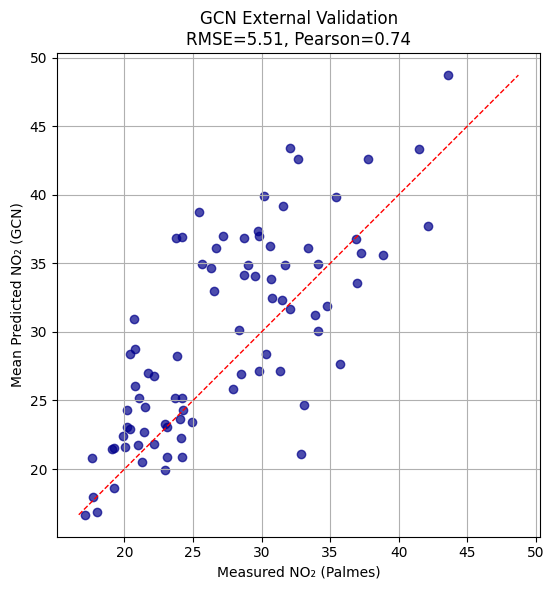

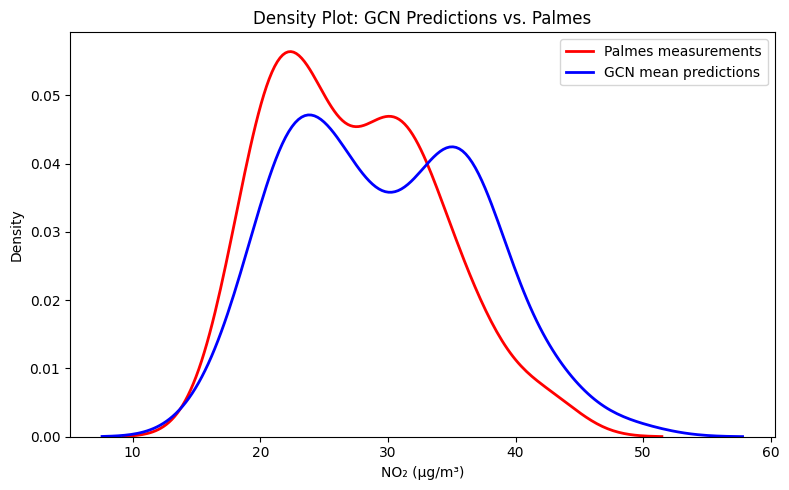

In [19]:
# ────────────────────────────────────────────────────────────
# External Validation – GCN (with density plot)
# ────────────────────────────────────────────────────────────

import seaborn as sns  # for the density/KDE plot

# 1) Compute GCN predictions for every node
model_GCN.eval()
with torch.no_grad():
    preds_gcn = model_GCN(data_GCN.x.to(device), data_GCN.edge_index.to(device))
all_preds_gcn = preds_gcn.cpu().numpy().flatten()
gdf['NO2_pred_GCN'] = all_preds_gcn

# 2) Load Palmes measurements and ensure matching CRS
palmes_fp  = '/content/drive/MyDrive/Universiteit Utrecht/Thesis/data/road_palmes_25m.geojson'
palmes_gdf = gpd.read_file(palmes_fp).to_crs(gdf.crs)

# 3) Build spatial index over gdf
sindex = gdf.sindex

# 4) Aggregate predictions at each tube location
mean_preds_gcn, actuals_gcn = [], []
for _, row in palmes_gdf.iterrows():
    pt = row.geometry
    candidates = list(sindex.intersection(pt.buffer(50).bounds))
    if candidates:
        dists = gdf.loc[candidates, 'geometry'].distance(pt).values
        nearby = [candidates[i] for i, d in enumerate(dists) if d <= 50]
    else:
        nearby = []
    if not nearby:
        nearby = [gdf.geometry.distance(pt).idxmin()]
    mean_preds_gcn.append(gdf.loc[nearby, 'NO2_pred_GCN'].mean())
    actuals_gcn.append(row['mean_annual_palmes_no2'])

# 5) Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

mse_gcn    = mean_squared_error(actuals_gcn, mean_preds_gcn)
rmse_gcn   = np.sqrt(mse_gcn)
mae_gcn    = mean_absolute_error(actuals_gcn, mean_preds_gcn)
pearson_gcn, _ = pearsonr(actuals_gcn, mean_preds_gcn)

print(f"GCN External   RMSE: {rmse_gcn:.2f}, MAE: {mae_gcn:.2f}, Pearson: {pearson_gcn:.2f}")

# 6) Scatter plot (Measured vs. Mean Predicted)
plt.figure(figsize=(6,6))
plt.scatter(actuals_gcn, mean_preds_gcn, alpha=0.7, color='darkblue')
mn, mx = min(min(actuals_gcn), min(mean_preds_gcn)), max(max(actuals_gcn), max(mean_preds_gcn))
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.xlabel('Measured NO₂ (Palmes)')
plt.ylabel('Mean Predicted NO₂ (GCN)')
plt.title(f'GCN External Validation\nRMSE={rmse_gcn:.2f}, Pearson={pearson_gcn:.2f}')
plt.grid(True)
plt.axis('square')
plt.tight_layout()
plt.show()

# 7) Density (KDE) Plot: Palmes vs. GCN Predictions
plt.figure(figsize=(8, 5))
sns.kdeplot(actuals_gcn, label='Palmes measurements', color='red', linewidth=2)
sns.kdeplot(mean_preds_gcn, label='GCN mean predictions', color='blue', linewidth=2)
plt.xlabel('NO₂ (µg/m³)')
plt.ylabel('Density')
plt.title('Density Plot: GCN Predictions vs. Palmes')
plt.legend()
plt.tight_layout()
plt.show()

## 3.4) Train & evaluate GAT with best hyperparameters

In this cell we:

1. **Move** the GAT‐specific Data object (`data_GAT`) to the selected device (CPU or GPU).  
2. **Instantiate** the GAT model using the optimal hyperparameters found by Optuna:
   - **`h_c=64`**: number of hidden units per head  
   - **`num_layers=4`**: total number of attention layers  
   - **`dropout=0.00139557`**, **`activation='relu'`**, **`heads=2`**  
3. **Set up** the optimizer (Adam) with the tuned learning rate and weight decay.  
4. **Train** for 200 epochs, recording both training and validation MSE at each step.  
5. **Evaluate** on the test mask to compute RMSE, MAE, R², and Pearson correlation.  
6. **Visualize** the learning curves (train vs. val loss) and the actual vs. predicted scatter.  

GAT Test   RMSE: 7.568, MAE: 5.103, R²: 0.635, Pearson: 0.803


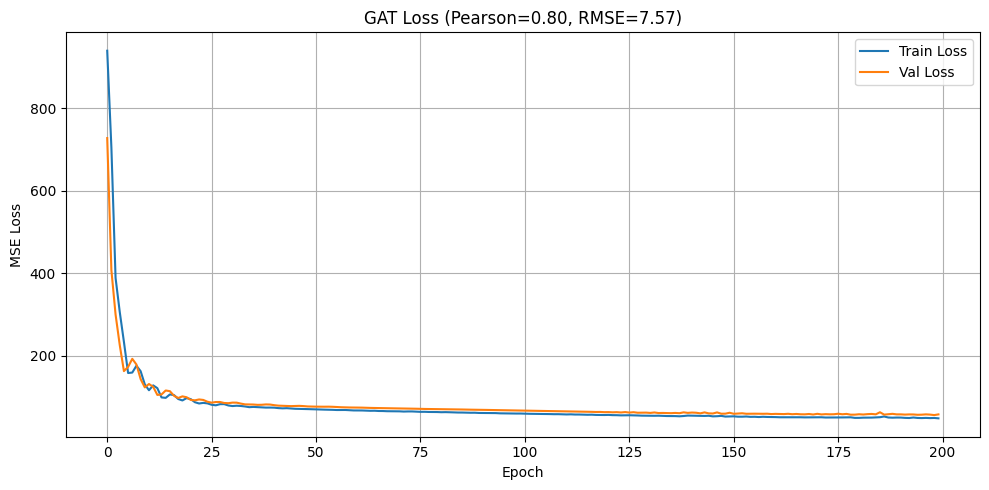

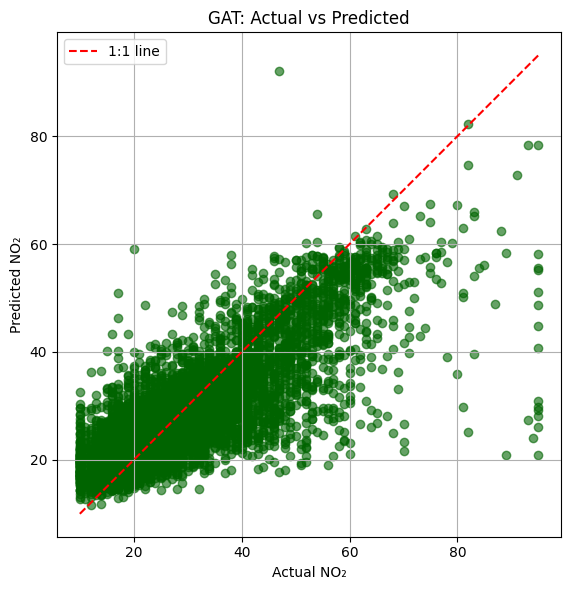

In [17]:
# ────────────────────────────────────────────────────────────
# 3.4) Train & evaluate GAT with best hyperparameters
# ────────────────────────────────────────────────────────────

# Move Data to device
data = data_GAT.to(device)

# Instantiate GAT (use positional args for in_c, h_c, out_c)
model_GAT = GAT(
    len(feature_cols),     # in_c: number of input features
    64,                    # h_c: hidden channels
    1,                     # out_c: output channels (regression)
    num_layers=4,
    dropout=0.041281979729126186,
    activation='relu',
    heads=2
).to(device)

optimizer = torch.optim.Adam(
    model_GAT.parameters(),
    lr=0.009195595431834305,
    weight_decay=2.7105564179485822e-05
)
loss_fn = nn.MSELoss()

torch.manual_seed(42)
train_losses, val_losses = [], []

for epoch in range(1, 201):
    model_GAT.train()
    optimizer.zero_grad()
    out = model_GAT(data.x, data.edge_index)
    train_loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()

    model_GAT.eval()
    with torch.no_grad():
        out = model_GAT(data.x, data.edge_index)
        val_loss = loss_fn(out[data.test_mask], data.y[data.test_mask])

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

# Compute final test metrics
model_GAT.eval()
with torch.no_grad():
    preds = model_GAT(data.x, data.edge_index)[data.test_mask].cpu().numpy().flatten()
    actuals = data.y[data.test_mask].cpu().numpy().flatten()

mse           = mean_squared_error(actuals, preds)
rmse          = np.sqrt(mse)
mae           = mean_absolute_error(actuals, preds)
r2            = r2_score(actuals, preds)
pearson_corr, _ = pearsonr(actuals, preds)

print(f"GAT Test   RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}, Pearson: {pearson_corr:.3f}")

# Plot train vs. validation loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'GAT Loss (Pearson={pearson_corr:.2f}, RMSE={rmse:.2f})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter: actual vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(actuals, preds, alpha=0.6, color='darkgreen')
mn, mx = min(actuals.min(), preds.min()), max(actuals.max(), preds.max())
plt.plot([mn, mx], [mn, mx], 'r--', label='1:1 line')
plt.xlabel('Actual NO₂')
plt.ylabel('Predicted NO₂')
plt.title('GAT: Actual vs Predicted')
plt.legend()
plt.axis('square')
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.5) External Validation – GAT

In this cell we compute and evaluate the GAT model’s predictions against the independent Palmes tube measurements:

1. **Predict** NO₂ for every road segment node using the trained `model_GAT`.  
2. **Attach** those predictions to `gdf` under a new column `NO2_pred_GAT`.  
3. **Reuse** the Palmes GeoDataFrame (`palmes_gdf`) and spatial index (`sindex`) to find all road nodes within 50 m of each tube.  
4. **Aggregate** the segment predictions (`NO2_pred_GAT`) by averaging over the nearby nodes for each tube location.  
5. **Compute** external‐validation metrics: RMSE, MAE, and Pearson correlation.  
6. **Visualize** measured vs. mean‐predicted NO₂ with a 1:1 reference line.  

GAT External   RMSE: 5.81, MAE: 4.40, Pearson: 0.70


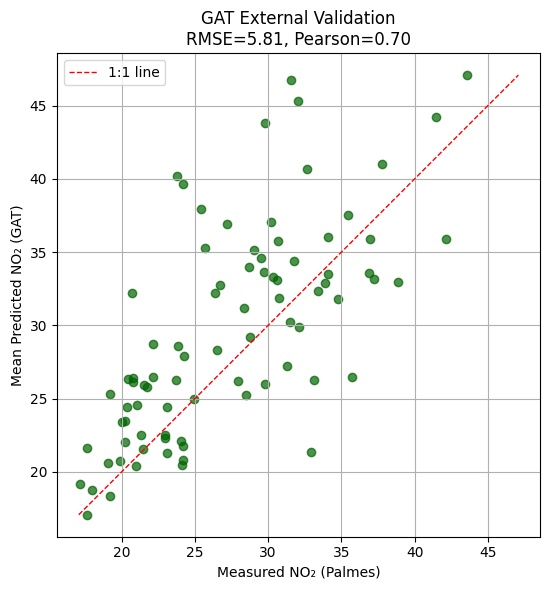

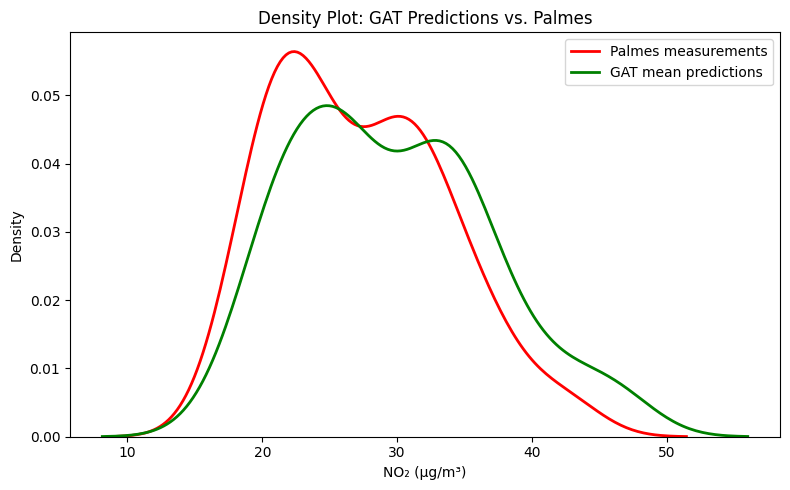

In [24]:
# ────────────────────────────────────────────────────────────
# External Validation – GAT (with density plot)
# ────────────────────────────────────────────────────────────

# 1) Compute GAT predictions for every node
model_GAT.eval()
with torch.no_grad():
    preds_gat = model_GAT(data_GAT.x.to(device), data_GAT.edge_index.to(device))
all_preds_gat = preds_gat.cpu().numpy().flatten()
gdf['NO2_pred_GAT'] = all_preds_gat

# 2) (palmes_gdf and sindex are already loaded above)

# 3) Aggregate GAT predictions at each tube
mean_preds_gat, actuals_gat = [], []
for _, row in palmes_gdf.iterrows():
    pt = row.geometry
    candidates = list(sindex.intersection(pt.buffer(50).bounds))
    if candidates:
        dists = gdf.loc[candidates, 'geometry'].distance(pt).values
        nearby = [candidates[i] for i, d in enumerate(dists) if d <= 50]
    else:
        nearby = []
    if not nearby:
        nearby = [gdf.geometry.distance(pt).idxmin()]
    mean_preds_gat.append(gdf.loc[nearby, 'NO2_pred_GAT'].mean())
    actuals_gat.append(row['mean_annual_palmes_no2'])

# 4) Compute external‐validation metrics
mse_gat      = mean_squared_error(actuals_gat, mean_preds_gat)
rmse_gat     = np.sqrt(mse_gat)
mae_gat      = mean_absolute_error(actuals_gat, mean_preds_gat)
pearson_gat, _ = pearsonr(actuals_gat, mean_preds_gat)

print(f"GAT External   RMSE: {rmse_gat:.2f}, MAE: {mae_gat:.2f}, Pearson: {pearson_gat:.2f}")

# 5) Scatter plot of measured vs. mean‐predicted
plt.figure(figsize=(6,6))
plt.scatter(actuals_gat, mean_preds_gat, alpha=0.7, color='darkgreen')
mn, mx = min(min(actuals_gat), min(mean_preds_gat)), max(max(actuals_gat), max(mean_preds_gat))
plt.plot([mn, mx], [mn, mx], 'r--', label='1:1 line', linewidth=1)
plt.xlabel('Measured NO₂ (Palmes)')
plt.ylabel('Mean Predicted NO₂ (GAT)')
plt.title(f'GAT External Validation\nRMSE={rmse_gat:.2f}, Pearson={pearson_gat:.2f}')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.tight_layout()
plt.show()

# 6) Density (KDE) Plot: Palmes vs. GAT Predictions
plt.figure(figsize=(8, 5))
sns.kdeplot(actuals_gat, label='Palmes measurements', color='red', linewidth=2)
sns.kdeplot(mean_preds_gat, label='GAT mean predictions', color='green', linewidth=2)
plt.xlabel('NO₂ (µg/m³)')
plt.ylabel('Density')
plt.title('Density Plot: GAT Predictions vs. Palmes')
plt.legend()
plt.tight_layout()
plt.show()

## 3.6) Combined Density Plot: Palmes vs. GCN vs. GAT

This code generates a single plot that visually compares the distribution of the external Palmes tube measurements against the aggregated predictions from both the GCN and GAT models. This helps to assess how well each model's predictions match the overall distribution of the real-world NO₂ levels recorded by the Palmes tubes.

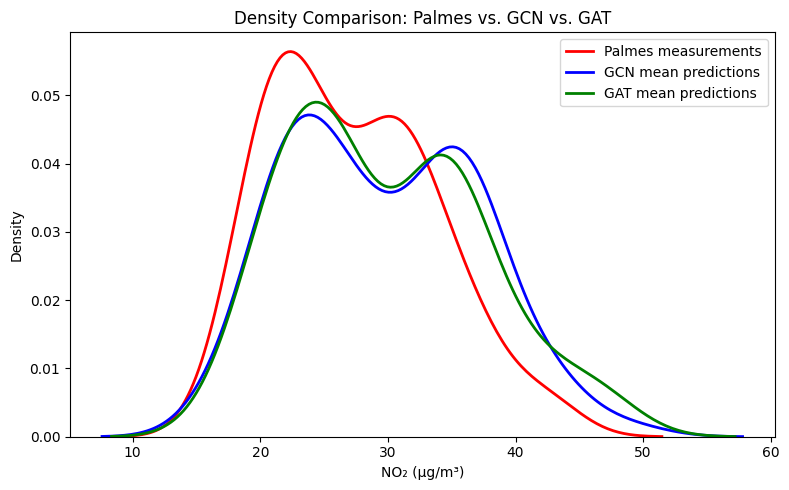

In [21]:
# ────────────────────────────────────────────────────────────
# Combined Density Plot: Palmes vs. GCN vs. GAT
# ────────────────────────────────────────────────────────────

import seaborn as sns  # make sure seaborn is installed

# (Re‐use the lists you already computed above:)
#   actuals_gcn (or actuals_gat—they should be the same Palmes values),
#   mean_preds_gcn, mean_preds_gat

plt.figure(figsize=(8, 5))

# Palmes measurements (actual)
sns.kdeplot(
    actuals_gcn,
    label='Palmes measurements',
    color='red',
    linewidth=2
)

# GCN‐based mean predictions
sns.kdeplot(
    mean_preds_gcn,
    label='GCN mean predictions',
    color='blue',
    linewidth=2
)

# GAT‐based mean predictions
sns.kdeplot(
    mean_preds_gat,
    label='GAT mean predictions',
    color='green',
    linewidth=2
)

plt.xlabel('NO₂ (µg/m³)')
plt.ylabel('Density')
plt.title('Density Comparison: Palmes vs. GCN vs. GAT')
plt.legend()
plt.tight_layout()
plt.show()